In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.data.xenium as xenium
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/xenium_grant'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config_xenium_multiplex.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/HT206B1/config_xenium_multiplex.yaml',
 '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config_xenium_multiplex.yaml']

In [6]:
xenium_config = {
    'dtype': 'multiplex',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'encoder_dim': 256,
        'kl_scaler': 0.,
        'recon_scaler': 1.,
        'neigh_scaler': .0,
        'codebook_size': 30,
        'decoder_dims': (256, 256, 256,)
    },
    'learner_kwargs': {
        'scale': 1.,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 5000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 200,
#         'save_dir': chkpt_dir       
    },
}

In [7]:
config_fp = '/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906/config_xenium_multiplex.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/{case}_xenium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [8]:
xenium_config['sections'] = config
xenium_config['train_kwargs']['save_dir'] = chkpt_dir
xenium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '4000iter.pt')

In [9]:
mushroom = Mushroom.from_config(xenium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 377 channels
INFO:root:4 sections detected: ['s0', 's2', 's4', 's6']
INFO:root:processing sections
INFO:root:generating image data for section s0
INFO:root:generating image data for section s2
INFO:root:generating image data for section s4
INFO:root:generating image data for section s6
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized


In [10]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's6'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

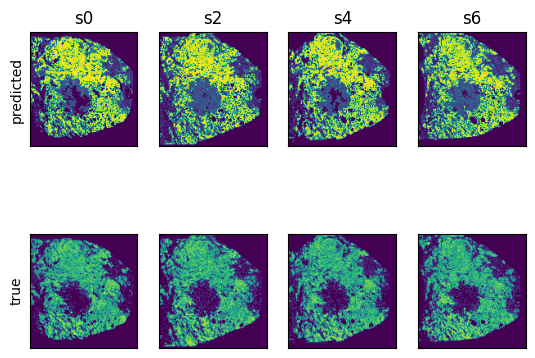

In [11]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's2'}>, <Axes: title={'center': 's4'}>,
        <Axes: title={'center': 's6'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

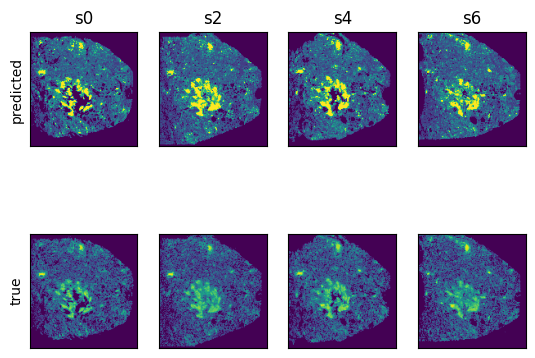

In [12]:
mushroom.display_predicted_pixels(channel='PTPRC')

In [13]:
cluster_ids = mushroom.cluster_ids.cpu().detach().numpy()

In [48]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 14 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 14 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'eight', 'five', 'four', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 2

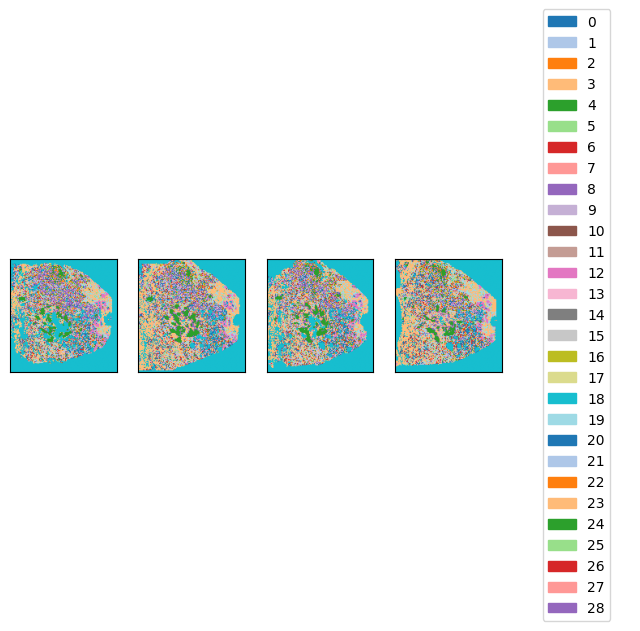

In [49]:
vis_utils.display_clusters(cluster_ids)
plt.savefig(os.path.join(out_dir, 'xenium_neighborhoods.pdf'))

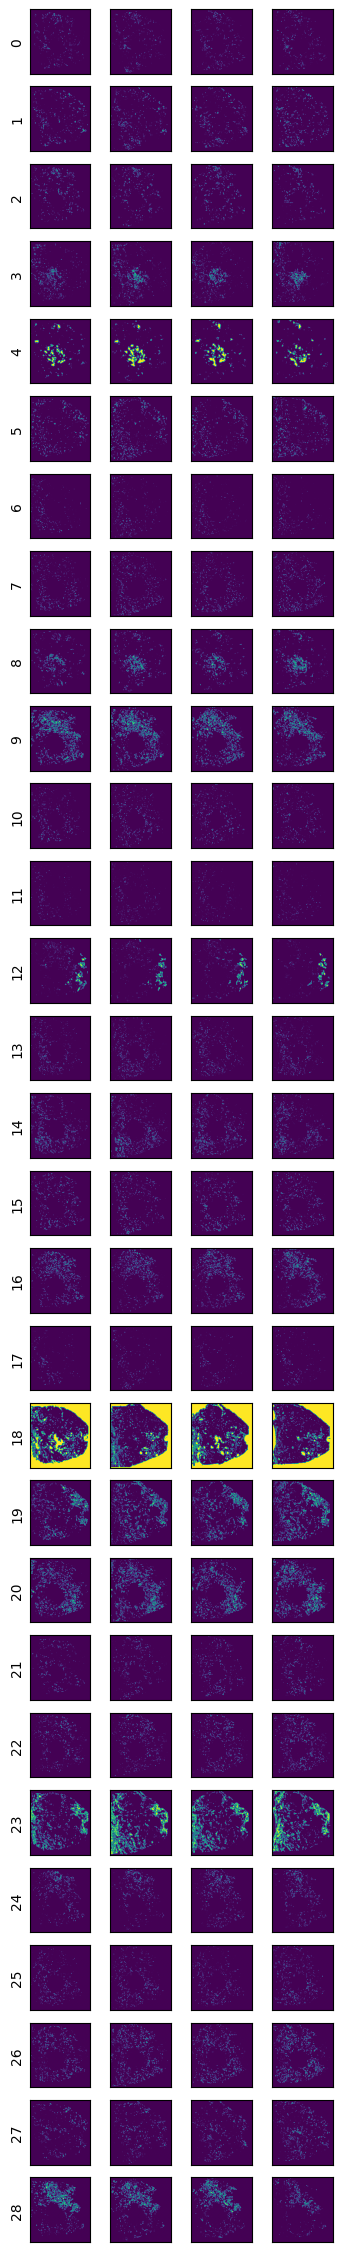

In [15]:
utils.display_cluster_probs(mushroom.cluster_probs)

In [16]:
# S18-9906	S18-9906-U2	xenium	0	0 
# S18-9906	S18-9906-U3	multiplex	1	5
# S18-9906	S18-9906-U9	xenium	2	35
# S18-9906	S18-9906-U10	multiplex	3	40
# S18-9906	S18-9906-U17	xenium	4	75
# S18-9906	S18-9906-U18	multiplex	5	80
# S18-9906	S18-9906-U24	xenium	6	110
# S18-9906	S18-9906-U25	multiplex	7	115

In [17]:
section_positions = (np.asarray([0, 35, 75, 110]) * .1).astype(int)
print(section_positions)
cluster_volume = utils.get_interpolated_volume(cluster_ids, section_positions)
cluster_volume.shape

[ 0  3  7 11]


(11, 140, 132)

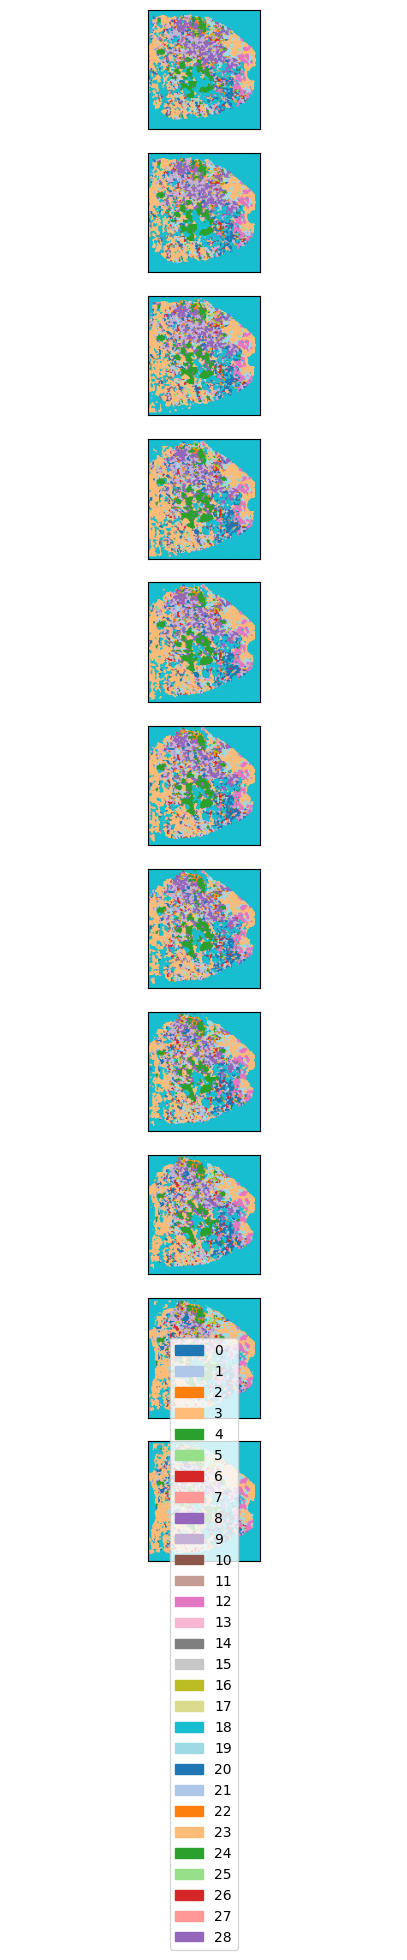

In [18]:
vis_utils.display_clusters(cluster_volume, horizontal=False)

In [19]:
probs = rearrange(mushroom.cluster_probs, 'n c h w -> c n h w').cpu().detach().numpy()
probs_volume = utils.get_interpolated_volume(probs, section_positions, method='linear')

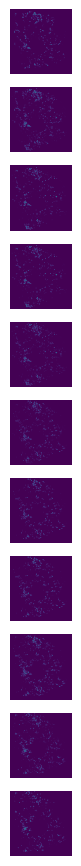

In [20]:
fig, axs = plt.subplots(nrows=probs_volume.shape[1], figsize=(5, probs_volume.shape[1]))
for i, ax in enumerate(axs):
    ax.imshow(probs_volume[0, i])
    ax.axis('off')
    

In [21]:
out_fp = os.path.join(out_dir, 'outputs.npy')
np.save(out_fp, {
    'cluster_ids': cluster_ids,
    'cluster_probs': probs,
    'cluster_volume': cluster_volume,
    'section_positions': section_positions
})


In [22]:
out_fp

'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906_xenium/outputs/outputs.npy'

In [23]:
gene_sets = {
    'T cell/NK': ['CD3D', 'CD4', 'FOXP3', 'GZMB'],
    'Macrophage': ['CD68', 'CD163'],
    'B cell': ['MS4A1'],
    'Fibroblast': ['ACTA2'],
    'Epithelial': ['EPCAM', 'KRT7'],
    'Endothelial': ['PECAM1']
}

for k, gs in gene_sets.items():
    for g in gs:
        if g not in mushroom.learner.channels:
            print(k, g)

In [24]:
cluster_df = mushroom.get_cluster_intensities(cluster_ids)
cluster_df

ABCC11      ACE2     ACKR1     ACTA2     ACTG2    ADAM28   ADAMTS1  \
0   0.388141  0.534508  0.420875  0.500847  0.525633  0.400908  0.629321   
1  -0.007802  0.371685  0.826939  0.616818  0.547327  0.290859  0.866729   
2   0.595376  0.654494  0.087601  0.440070  0.493445  0.489728  0.337310   
3  -0.204727 -0.112883  0.014025  0.619906  0.594122  0.199159  0.334619   
4  -0.052961  0.259595  0.455703  0.196472  0.416016  0.928540  0.151262   
5  -0.141003  0.126451  0.594840  0.688215  0.632586  0.017924  0.749105   
6   0.083594  0.147476  0.257988  0.440460  0.460636 -0.025969  0.417426   
7   0.527844  0.479347  0.392064  0.362818  0.393573  0.051822  0.512937   
8  -0.065805  0.129572  0.198211  0.573299  0.591500  0.527402  0.385146   
9   0.773565  0.573899 -0.011593  0.111098  0.206103  0.037393  0.038771   
10  0.533039  0.461484  0.005964  0.291944  0.351049  0.229569  0.189894   
11  0.321552  0.285853  0.185813  0.365539  0.408885  0.056903  0.353476   
12  0.649195  0.780018  0.114576  0.349745  0.426615  0.453032  0.513766   
13  0.060102  0.036487 -0.056337  0.640778  0.638630  0.079303  0.352625   
14  0.051799 -0.029682 -0.094064  0.226875  0.259152 -0.092018  0.020427   
15  0.532174  0.669776  0.618583  0.370128  0.392335  0.196243  0.709460   
16  0.624121  0.480187 -0.036469  0.538856  0.566204  0.054041  0.282040   
17  0.284949  0.356799  0.363342  0.494938  0.507625  0.205916  0.578245   
18 -0.368517 -0.402182 -0.148286 -0.799858 -0.858282 -0.242067 -0.566920   
19 -0.230776 -0.134571 -0.058094  0.945828  0.945666  0.018202  0.524365   
20  0.417742  0.216671 -0.063833 -0.100907  0.001375 -0.057885 -0.128852   
21  0.227609  0.221452 -0.015108  0.703966  0.723277  0.317173  0.471616   
22  0.219449  0.166188 -0.026374  0.816221  0.820161  0.090467  0.509586   
23 -0.291821 -0.230956 -0.074398  0.700196  0.712274 -0.128459  0.283188   
24  0.612965  0.545725  0.013282  0.617842  0.666081  0.219516  0.430130   
25  0.346969  0.228417 -0.067029  0.475766  0.494726  0.095496  0.239176   
26  0.290117  0.162413 -0.064265  0.648377  0.665949 -0.044803  0.296647   
27 -0.157035 -0.037887  0.088931  0.892214  0.880166  0.240910  0.628432   
28  0.921012  0.907476  0.086321  0.273306  0.338938  0.187340  0.258518   

      ADGRE1    ADGRL4     ADH1C  ...      TRAC     TREM2   TSPAN19     UBE2C  \
0   0.357601  0.497523  0.751149  ...  0.408779  0.257133  0.470269  0.595911   
1   0.245365  0.835129  0.517837  ...  0.353460  0.165645  0.196512  0.293466   
2   0.447198  0.137804  0.831955  ...  0.450096  0.385052  0.722282  0.818661   
3   0.073250  0.010713  0.280494  ...  0.430185  0.047861 -0.115901 -0.016320   
4   0.916219  0.262319  0.312767  ...  0.939776  0.904815  0.318924  0.792530   
5  -0.001579  0.623111  0.260697  ...  0.113144 -0.030569 -0.022235 -0.032531   
6  -0.035259  0.304296  0.179371  ...  0.074289 -0.032284  0.078886  0.031343   
7   0.115588  0.502192  0.417024  ...  0.081576  0.022906  0.421009  0.389850   
8   0.412779  0.169035  0.520547  ...  0.703569  0.333036  0.148641  0.392734   
9   0.196010  0.050348  0.415254  ... -0.013197  0.006484  0.661566  0.580451   
10  0.220073  0.057843  0.462608  ...  0.250179  0.181335  0.550681  0.488503   
11  0.053740  0.251371  0.302089  ...  0.136736  0.034961  0.278287  0.204524   
12  0.322869  0.269554  0.742964  ...  0.232998  0.216692  0.579802  0.689469   
13  0.013002 -0.023845  0.384708  ...  0.200342  0.038706  0.067903  0.033126   
14 -0.066251 -0.084468 -0.050108  ... -0.039957 -0.051917 -0.004919 -0.094958   
15  0.250553  0.740726  0.618974  ...  0.185960  0.116356  0.510433  0.576946   
16  0.158717  0.021456  0.656154  ...  0.038348  0.009829  0.533543  0.499175   
17  0.156114  0.445605  0.489143  ...  0.276901  0.111178  0.303845  0.321509   
18 -0.222880 -0.188506 -0.668861  ... -0.274441 -0.147757 -0.400860 -0.456715   
19 -0.037268 -0.034707  0.434942  ...  0.116671 -0.043511 -0.158644 -0.138576   
20  0.046028 -0.037871  

In [25]:
score_df = {}
for k, gs in gene_sets.items():
    score_df[k] = cluster_df[gs].values.sum(1)
score_df = pd.DataFrame.from_dict(score_df)
score_df.index = cluster_df.index.to_list()
score_df 

T cell/NK  Macrophage    B cell  Fibroblast  Epithelial  Endothelial
0    1.200376    0.940265  0.341041    0.500847    0.746222     0.638333
1    0.971834    0.889411  0.276447    0.616818    0.253633     0.887119
2    1.541599    0.923020  0.401557    0.440070    0.909617     0.360392
3    0.833345    0.848905  0.299461    0.619906   -0.199413     0.257946
4    3.685736    1.878951  0.934893    0.196472   -0.103669     0.897218
5    0.089894    0.242314 -0.015085    0.688215   -0.062697     0.588899
6   -0.011803    0.094179 -0.042918    0.440460    0.291035     0.308734
7    0.207436    0.060790  0.013627    0.362818    0.813457     0.451774
8    2.057596    1.423112  0.682168    0.573299    0.016739     0.547869
9    0.154874   -0.209246  0.053551    0.111098    0.934380    -0.026921
10   0.766435    0.475920  0.179648    0.291944    0.904463     0.170451
11   0.253270    0.211266  0.026718    0.365539    0.678609     0.284402
12   0.910780    0.252631  0.087021    0.349745    1.530598     0.343020
13   0.267691    0.373357  0.060672    0.640778    0.370542     0.083640
14  -0.269156   -0.157104 -0.095761    0.226875    0.298278    -0.115469
15   0.561879    0.375858  0.118351    0.370128    0.868724     0.706321
16   0.132964   -0.123833  0.043507    0.538856    0.866474    -0.024625
17   0.636736    0.598586  0.153044    0.494938    0.673295     0.529780
18  -0.801680   -0.488624 -0.193911   -0.799858   -0.619426    -0.296860
19  -0.086056    0.215957 -0.015910    0.945828   -0.234813     0.038285
20  -0.172253   -0.300362 -0.044519   -0.100907    0.723950    -0.124293
21   0.901074    0.884109  0.273549    0.703966    0.608043     0.244246
22   0.143112    0.227157  0.042381    0.816221    0.530811     0.085403
23  -0.439708   -0.154092 -0.120131    0.700196   -0.434636    -0.103540
24   0.547829    0.337538  0.172272    0.617842    0.855760     0.153771
25   0.302949    0.275285  0.058537    0.475766    0.772946     0.049930
26  -0.155750   -0.151825 -0.054667    0.648377    0.606705    -0.071340
27   0.637530    0.837804  0.230801    0.892214   -0.017977     0.310983
28   0.635431    0.049020  0.156777    0.273306    1.010090     0.157955

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'G', 'L', 'M', 'N', 'P', 'S', 'T', 'X', 'Y', 'Z', 'eight', 'five', 'four', 'minus', 'nine', 'nonmarkingreturn', 'one', 'period', 'seven', 'six', 'space', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 42, 47, 48, 49, 51, 54, 55, 59, 60, 61, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 31 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C',

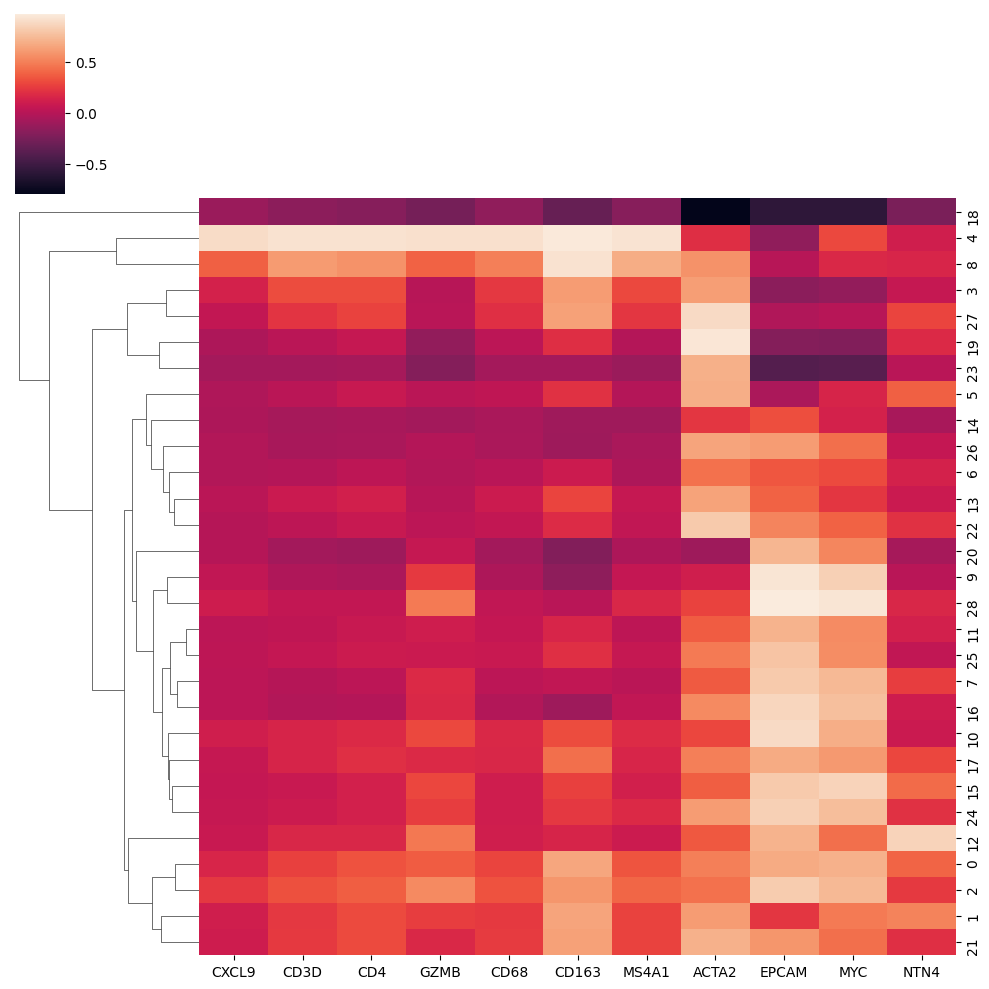

In [50]:
sns.clustermap(
    cluster_df[['CXCL9', 'CD3D', 'CD4', 'GZMB', 'CD68', 'CD163', 'MS4A1', 'ACTA2', 'EPCAM', 'MYC', 'NTN4']],
    row_cluster=True, col_cluster=False
)
plt.savefig(os.path.join(out_dir, 'xenium_genes_heatmap.pdf'))

In [51]:
out_dir

'/data/estorrs/mushroom/data/projects/xenium_grant/mushroom/S18-9906_xenium/outputs'

In [ ]:
20,9,28,11,25,7,16,10,17,15,24

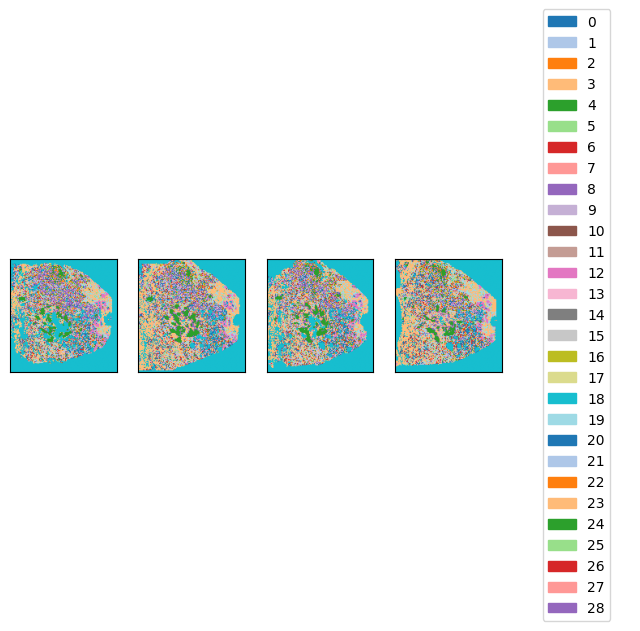

In [30]:
vis_utils.display_clusters(cluster_ids)

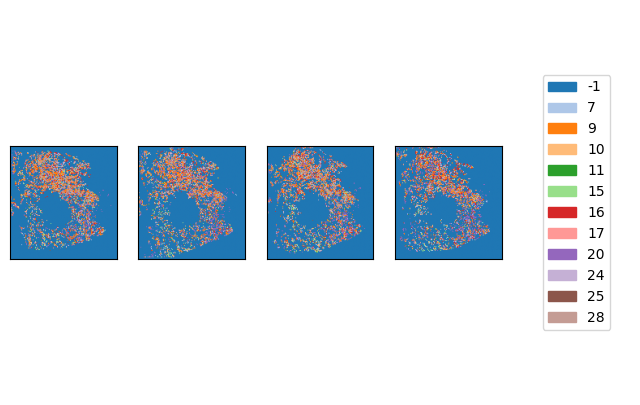

In [47]:
groups = [20,9,28,11,25,7,16,10,17,15,24] 

vis_utils.show_groups(cluster_ids, groups)

In [55]:
import mushroom.data.multiplex as multiplex

In [52]:
config

[{'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s0_multiplex.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex_codex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 35},
 {'data': [{'dtype': 'multiplex_codex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s3_multiplex.ome.tiff'}],
  'id': 's3',
  'position': 40},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s4_multiplex.ome.tiff'}],
  'id': 's4',
  'position': 75},
 {'data': [{'dtype': 'multiplex_codex',
    'filepath': '/data/estorrs/mushroom/data/proje

In [54]:
fps = [mapping['filepath'] for entry in config for mapping in entry['data'] if mapping['dtype']=='multiplex_codex']
fps

['/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s1_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s3_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s5_multiplex.ome.tiff',
 '/data/estorrs/mushroom/data/projects/xenium_grant/registered/S18-9906/s7_multiplex.ome.tiff']

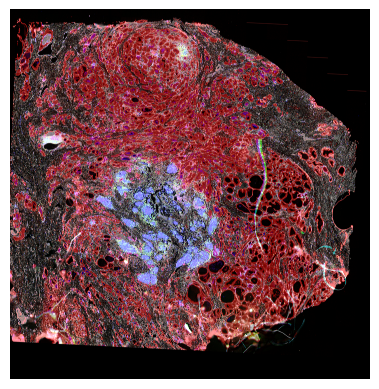

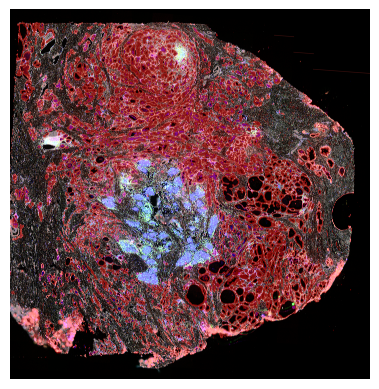

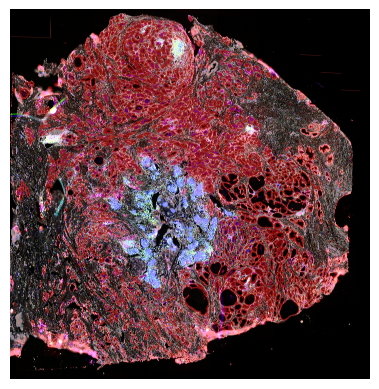

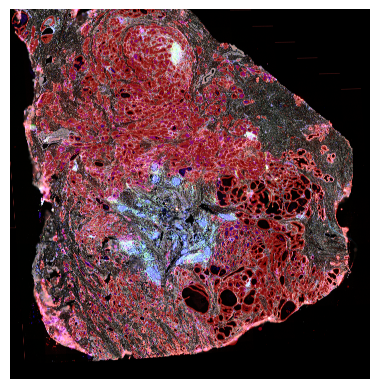

In [94]:
# bbox = (6000, 7000, 3000, 4000)
bbox = None
scale = .1

cmap = {
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD3e': (0., 1., 0.),
    'Vimentin': (1., 1., 1.),
#     'SMA': (1., 1., 0.),
    'HLA-DR': (0., 0., 1.),
}
contrast_mapping = {
    'Pan-Cytokeratin': 40.,
    'CD3e': 98.,
    'HLA-DR': 90.,
    'Vimentin': 80.,
#     'CD31': 99.,
}

for fp in fps:
    channel_to_img = multiplex.extract_ome_tiff(fp, bbox=bbox, scale=scale)
    rgb = multiplex.make_pseudo(
        {c:img for c, img in channel_to_img.items() if c in cmap},
        cmap=cmap, contrast_mapping=contrast_mapping)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

In [96]:
'HLA-DRA' in mushroom.learner.channels

False

In [97]:
mushroom.learner.channels

['ABCC11',
 'ACE2',
 'ACKR1',
 'ACTA2',
 'ACTG2',
 'ADAM28',
 'ADAMTS1',
 'ADGRE1',
 'ADGRL4',
 'ADH1C',
 'ADH4',
 'ADIPOQ',
 'AGER',
 'AGR3',
 'AHSP',
 'AIF1',
 'ALAS2',
 'ALDH1A3',
 'AMY2A',
 'ANGPT2',
 'ANPEP',
 'APCDD1',
 'APOA5',
 'APOBEC3A',
 'APOLD1',
 'AQP2',
 'AQP3',
 'AQP8',
 'AQP9',
 'AR',
 'ARFGEF3',
 'ASCL1',
 'ASCL3',
 'ASPN',
 'BAMBI',
 'BANK1',
 'BASP1',
 'BBOX1',
 'BCL2L11',
 'BMX',
 'BTNL9',
 'C15orf48',
 'C1orf162',
 'C1orf194',
 'C20orf85',
 'C5orf46',
 'C6orf118',
 'C7',
 'CA4',
 'CAPN8',
 'CAV1',
 'CAVIN1',
 'CAVIN2',
 'CCDC39',
 'CCDC78',
 'CCL19',
 'CCL27',
 'CCL5',
 'CCNB2',
 'CCR2',
 'CCR7',
 'CD14',
 'CD163',
 'CD19',
 'CD1A',
 'CD1C',
 'CD1E',
 'CD2',
 'CD247',
 'CD27',
 'CD274',
 'CD28',
 'CD300E',
 'CD34',
 'CD3D',
 'CD3E',
 'CD4',
 'CD5L',
 'CD68',
 'CD69',
 'CD70',
 'CD79A',
 'CD83',
 'CD86',
 'CD8A',
 'CD93',
 'CDH16',
 'CDK1',
 'CENPF',
 'CFAP53',
 'CFB',
 'CFHR1',
 'CFHR3',
 'CFTR',
 'CHGA',
 'CLCA1',
 'CLCA2',
 'CLEC10A',
 'CLEC14A',
 'CLEC4E',
 'CLE

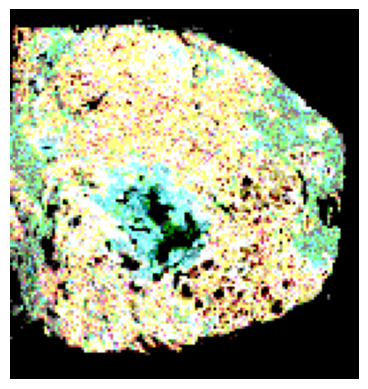

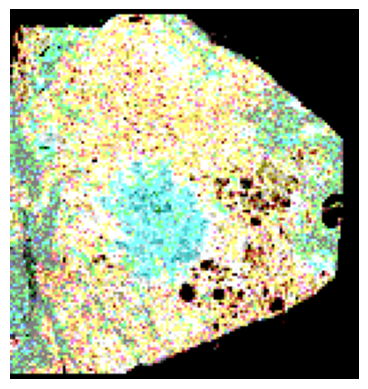

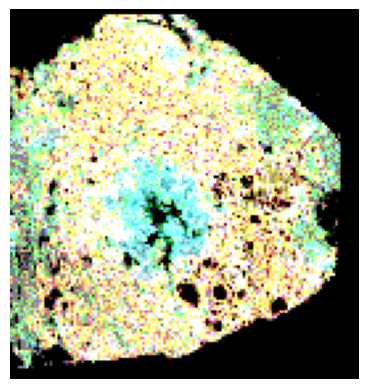

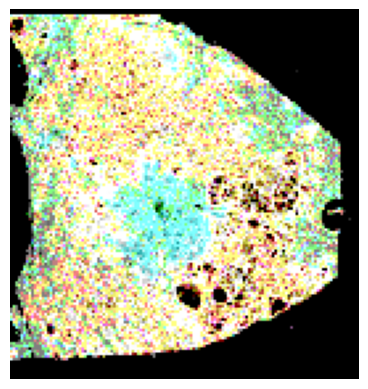

In [98]:
cmap = {
    'EPCAM': (1., 0., 0.),
    'PTPRC': (0., 1., 0.),
    'ACTA2': (1., 1., 1.),
    'HLA-DQB2': (0., 0., 1.),
}
# contrast_mapping = {
#     'Pan-Cytokeratin': 40.,
#     'CD3e': 98.,
#     'HLA-DR': 90.,
#     'Vimentin': 80.,
# #     'CD31': 99.,
# }

for img in mushroom.true_imgs:
    channel_to_img = {c:img[i].numpy() for i, c in enumerate(mushroom.learner.channels)
                     if c in cmap}
    rgb = multiplex.make_pseudo(
        channel_to_img, cmap=cmap, contrast_pct=)
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

In [64]:
mushroom.true_imgs[0].shape

torch.Size([377, 140, 132])

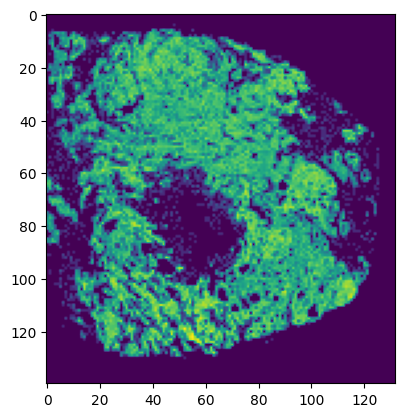

In [66]:
plt.imshow(mushroom.true_imgs[0, mushroom.learner.channels.index('EPCAM')])